# Introduction:

This notebook is a practical example of the steps taken in multivariate linear regression. I tried to be as generic as possible, but in reality every dataset is unique and requires slightly different treatment. If you noticed any missing or unnecessary steps don't hesitate to leave a comment :) 

Let's denote the dependent variable as $Y$, and the independent variables (features) $X ~ (x_1, x_2\dots x_n)$.  
 

# 1. Ask the Right Question:
   
First and formost is to state the objective of the analysis and be very clear about it. Here we're building a model to predict the price of used BMW given a list of features (age, mileage, color...etc)  
Let's begin by importing the libraries needed. I keept the libraries in `txt` file so the notebook is tidy!

In [1]:
with open('requirements.txt','r') as file:
    req = file.read()
exec(req)

In [2]:
%matplotlib inline

# 2. Read & Clean Data:
The second step is gather data. But in our case we're using a ready multivariate dataset that contains selling prices of +4800 used BMW cars and their models, mileage, color, fuel type...etc


In [3]:
filename = 'bmw_pricing_challenge.csv'
dirname = '.'

df = pd.read_csv(os.path.join(dirname, filename), parse_dates=['registration_date','sold_at'])
df.head(3)

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01


## 2.1 Examin data types & corrupt data:

Looking at the table above I noticed the following:
- There are 12 categorical variable and 3 continuous (including dependent variable)
- We can calculate the age of each car at time of sale from the two date fields `registration_date` and `sold_at`
- I think car's model is relevant when it comes to predicting price. But `model_key` column has way too many categories, so I'm going to combine them into fewer values in a new field using BMW series model.

In [4]:
#Calculate age ~ the time in years between registering the car and selling it
df['age'] = (df.sold_at - df.registration_date).dt.days / 365


#Assign categorical variables
cat_cols = ['model_key', 'fuel','paint_color','car_type',
            'feature_1','feature_2','feature_3','feature_4',
            'feature_5','feature_6','feature_7','feature_8']
cont_cols = ['mileage','engine_power','price','age']

The next step is to examin the continuous $X$ and $Y$ variables:

In [5]:
df[cont_cols].describe()

,mileage,engine_power,price,age
count,4.843000e+03,4843.00000,4843.000000,4843.000000
mean,1.409628e+05,128.98823,15828.081767,5.434862
std,6.019674e+04,38.99336,9220.285684,2.540489
min,-6.400000e+01,0.00000,100.000000,0.589041
25%,1.029135e+05,100.00000,10800.000000,4.079452
50%,1.410800e+05,120.00000,14200.000000,4.835616
75%,1.751955e+05,135.00000,18600.000000,5.835616
max,1.000376e+06,423.00000,178500.000000,28.104110


Right off the bat, mileage cannot be negative and engine power can't be zero! So let's fix them assuming they're data gathering errors 


In [6]:
# change the sign of mileage to positive

df.mileage = df.mileage.apply(lambda x: abs(x))

In [7]:
# fix the record with zero engine horse power
df[df.engine_power <=0]

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at,age
3765,BMW,X1,81770,0,2014-10-01,diesel,white,suv,False,False,False,False,False,False,False,False,11700,2018-03-01,3.416438


In [8]:
# replace zero engine power with the median of car
df.engine_power[df.engine_power==0] = \
df[(df.model_key =='X1')&(df.fuel =='diesel')&(df.age < 3.5)].engine_power.median()

In [9]:
# check if there is any N/As in the dataset
print(df.isna().sum())

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
age                  0
dtype: int64


**Conclusion:** No N/As to worry about.

## 2.2 Outliers

Sometimes outliers are bad data that you must get rid of, and sometimes they're Michael Jordan or Shaquille O'Neal and you should keep. Either way, outliers must be identified before dealing with them.  
The two most common definitions of outliers are: 
1. Observations that are more than 3 standard deviations away from the mean.
2. Observations that are more than 1.5 * Inter-Quartile-Range (IQR) below/above the 25th/75th percentiles (ends of the boxplot).

Current data contains one continuous and one categorical (discrete) variables. So a simple boxplot should reveal any outliers.  

**More on outliers detection**   
The most common tecniques used to identify outliers by data types is:  
- Univariate data -> boxplot. outside of 1.5 times inter-quartile range is an outlier.  
- Bivariate -> scatterplot with confidence ellipse. outside of, say, 95% confidence ellipse is an outlier.  
- Multivariate -> Mahalanobis D2 distance   

Once defined, mark those observations as outliers. Then run a logistic regression to see if there are any systematic patterns. 

In [10]:
# We only examin outliers in continuous variables
fig = px.box(df[cont_cols].melt(var_name='variable'),
             color='variable',
             facet_col='variable',
             boxmode='overlay')
fig.update_yaxes(matches=None)
fig.show()

**Conclusion:**
There are clearly some outliers in $X$ and $Y$, but at this point I'm going to leave them as is. Because they appear to be extreme readings. I will revisit this assumption after building the model though 

## 2.3 Imbalances:

In general, having balanced data results in higher accuracy models. An underrepresented group can lead to an insignificant coefficient.  
This is true for all regression types and machine learning algorithms. 

In [11]:
fig = go.Figure()
for col in cat_cols:
    d = df.groupby(col).size().to_frame(col).T
    f = px.bar(d, orientation='h')
    for o in f.data:
        fig.add_trace(o)
fig.update_layout(showlegend=False, barmode='stack', title='Distribution of Data across Categorical Variables')
fig.show()

Bar plots across categorical variables reveal some underrepresented categories. An obvious example is the small number of petrol and electric cars vs. diesel, which doesn't represent the population!  
Another example is the imbalance between `paint_color` sub-categories. This is justifiable because some car colors are more popular. Same goes for `key_model` and `car_type` (Convertable, Coupe, subcompacts, and vans)    


**Conclusion**  
Sample data should reflect the population irrespective of how extreme we perceive it. It should also make economic sense! 
One of the consequences is ending up with insignificant coefficients. That said, I'm going to merge the underrepresented categories to make a more readable model, and to avoid failing coefficient *t-test*.

In [12]:
# Roll up model_key into model by series
df['model'] = 'Other'
for i in range(1,8):
    idx = df[df.model_key.str.startswith(str(i))].index
    df.model.loc[idx] = str(i) + ' series'
cat_cols.append('model')

# Merge minority colors
df['color'] = np.where(df.paint_color.isin(['beige','green','orange','red']), 'other', df.paint_color)
cat_cols.remove('paint_color')
cat_cols.append('color')
# Drop electric and hybrid cars

df.drop(index=df[df.fuel.isin(['hybrid_petrol','electro'])].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
fig = go.Figure()
cat_cols.remove('model_key')
for col in cat_cols:
    d = df.groupby(col).size().to_frame(col).T
    f = px.bar(d, orientation='h')
    for o in f.data:
        fig.add_trace(o)
fig.update_layout(showlegend=False, barmode='stack', title='Distribution of Data across Categorical Variables')
fig.show()

## 2.4 Relationship between Variables
To examin the relationship between varaibles we can:
1. scatter plot them against each other
2. heatmap the correlation between them
So let's do that:

In [14]:
# scatter = ff.create_scatterplotmatrix(df[cont_cols],
#                                       diag='histogram',
#                                       height=900, width=900,
#                                       title='BMW Scatter Plot')
# scatter.show()

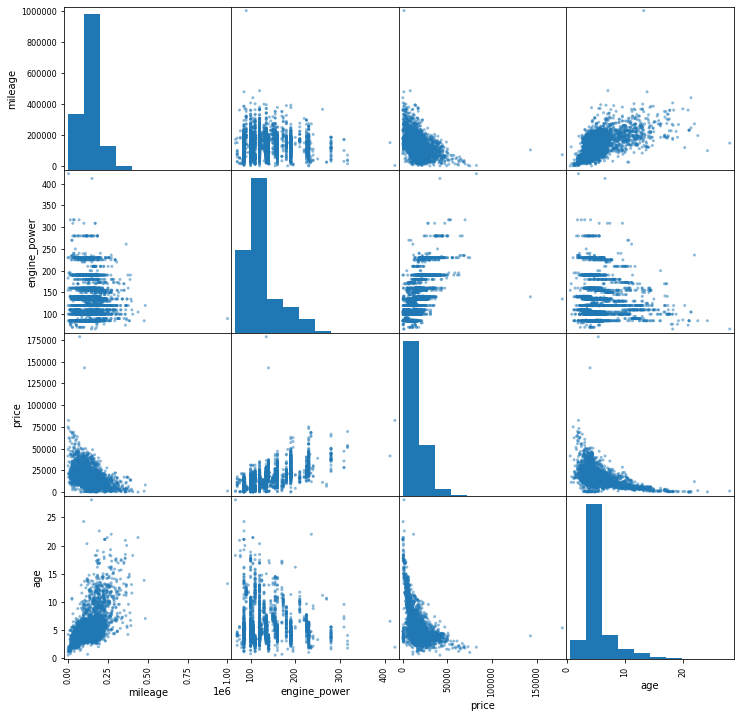

In [15]:
pd.plotting.scatter_matrix(df[cont_cols], figsize=(12,12));

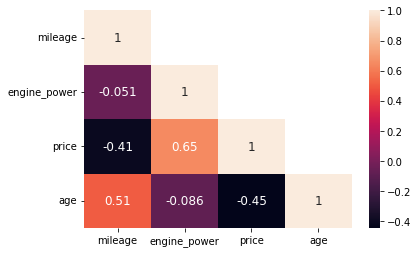

In [16]:
mask = np.ones_like(df[cont_cols].corr(), dtype=bool)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(df[cont_cols].corr(), annot=True, mask=mask, annot_kws=dict(fontsize=12));

**Conclusion**:  
1. None of of the continuous variables is normally distributed. Therefor, I don't expect the residuals to be normally distributed (not without transforming variables that is)
2. There appears to be negative relationships between `price` and each of `mileage`, `age`, albeit not stright lines! This is confimred by their moderate negative correlation of `-0.41` and `-0.45` respectively.

3. Engine power and price have moderate positive relationship that appears to be linear. This makes economic sense since higher engine power is indicative of more expensive sport or luxury models.
4. There's a moderate positive correlation between the explanatory variables `age` and `mileage`. This make sense as we expect older cars to have more mileage. This is something to keep an eye on when testing/correcting multicollinearity


# 3. Analyzing Data

This step should answer the question in step (1).i.e. predict BMW cars' prices given a set of their specifications and features. 

### 3.2 Pre-Processing
#### 3.2.1 Split Data

It's standard practice to split the data into training and test sets to see how the model behaves when presented with data it hasn't seen. 

In [17]:
# Split the data into train and test sets

train_idx, test_idx = train_test_split(df.index, test_size=.25)
df_train = df.iloc[train_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

print(f'Size of training set:{len(df_train)}, size of test set: {len(df_test)}\n')

Size of training set:3624, size of test set: 1208



#### 3.2.2 Normalize data (optional)
Normalizing data improves numerical stability and produces cleaner results. It doesn't improve accuracy or prediction power though

In [18]:
# Scale the data (optional)

from sklearn.preprocessing import MinMaxScaler
cont_x = ['mileage','engine_power','age']
scalar = MinMaxScaler()
scalar.fit(df[cont_x])
dfc = df.copy()
dfc[cont_x] = scalar.transform(dfc[cont_x])

dfc_train = dfc.iloc[train_idx].reset_index(drop=True)
dfc_test = dfc.iloc[test_idx].reset_index(drop=True)

#### 3.2.3 Predictor function
It's more convenient to write a function to return $R^2$ of test data

In [19]:
def pred(res, x, y, log=False):
    y_hat = res.predict(x)
    if log:
        y_hat = np.exp(y_hat)
    r2 = r2_score(y,y_hat)
    print(f'R-squared: {r2:.2f}')

### 3.3 Model Selection
The most challenging step in any analysis is specifying the model to use; is it linear, log-linear, quadratic or non-linear!? Which variables to omit and which to transform! What kind of transformation (polynomial, log)...etc.   
When it comes to model selection keep in mind that the model's job is to approximate, and not perfectly represent reality. So keep it simple, but not too simple! 
You must be able to explain the relationship in terms of how a unit increase in $X_i$ changes $Y$. And explain the economic sense of the model and how it adheres to its assumptions.  

#### 3.3.1 Manual  approach
It's always good to examin the scatter plot and correlation matrix first to get a sense of the relationship between variables. From there write down an initial formula for the model, and build on it. 

In [61]:
formula_manual = '''
np.log(price)~age+np.power(age,2)+mileage+np.power(mileage,2)+engine_power+model+fuel+color
+feature_1+feature_2+feature_3+feature_4
+feature_5+feature_6+feature_7+feature_8
'''

ols_manual = smf.ols(formula_manual, df_train)
res_manual = ols_manual.fit()
print(res_manual.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     315.2
Date:                Fri, 12 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:19:03   Log-Likelihood:                -1341.8
No. Observations:                3624   AIC:                             2740.
Df Residuals:                    3596   BIC:                             2913.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.1713 

In [67]:
# R2 of test-data

pred(res_manual, x=df_test, y=df_test.price, log=True)

R-squared: 0.82


### 3.3.1 Forward Model Selection
Another approach is to use a *forward selection* algorithm. It applies brute force to fit all the possible combinations of variables and pick the one/s with the best metrics (AIC, BIC, R2 Adjusted ... etc.)   
The approach is greedy by nature, which means we'll end up omitting some variables the algorithm had included!

In [44]:
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm

class ForwardModelSelector:
    """
    Ordinary Least Square forward selection algorithm. It regresses every possible combination of the 
    x_cols variables with y_col and store the metrices in summary_frame
    """
    def __init__(self, x_cols , y_col, df, subset=None, metrics=['aic','bic','rsquared_adj']):
        """
        x_cols: list of the independent variables
        y_col : str represents the dependent variable or a transformation version of it. Takes np.log, center
        or a custom function
        df    : pandas dataframe contains x's and y
        subset: numpy array or pandas indexes to train on subset of the data (training set)
        metrics: list of metrics to save in summary_frame. Default is aic, bic and rsquared_adj
        
        """
        self.x_cols = x_cols
        self.y_col = y_col
        self.df = df
        self.subset = subset
        self.metrics = metrics
        self.res = defaultdict(list)
        self.left = str(y_col) + '~'
        self.n = 0
        pass
    
    def generate_formulas(self):
        """Generate a list of formulas using all possible combinations of x variables"""
        self.formulas = []
        for i in range(1,len(self.x_cols)):
            self.formulas.extend(list(map(' + '.join, combinations(x_cols, r=i))))
        pass
    
    def fit(self):
        """Regress using the repository of generated formulas and save results in dataframe"""
        self.generate_formulas()
        for right in tqdm(self.formulas):
            self.n += 1
            f_tmp = self.left + right
            self._update_(f_tmp)
        print(f'Finished trying {self.n} combinations')
        self.frame = pd.DataFrame(self.res, index=self.metrics+['n_variables']).T.reset_index().rename(columns={'index':'formula'})
    
    def _update_(self, formula):
        ols_tmp = smf.ols(formula, self.df, subset=self.subset).fit()
        for m in self.metrics:
            self.res[formula].append(getattr(ols_tmp,m))
        self.res[formula].append(ols_tmp.model.exog.shape[1])
        pass
    
    def summary_frame(self, sort_by=None, ascending=None):
        if sort_by is None:
            return self.frame.sort_values(self.metrics)
        return self.frame.sort_values(sort_by, ascending=ascending)


In [45]:
x_cols = ['age','np.power(age,2)','mileage','np.power(mileage,2)','engine_power'] + cat_cols

m = ForwardModelSelector(x_cols, 'np.log(price)', df, subset=train_idx, metrics=['aic','bic','rsquared_adj','fvalue'])
m.fit()

100%|██████████| 131070/131070 [48:47<00:00, 44.77it/s]


Finished trying 131070 combinations


The algorithm tried 131,070 combinations of $x$ variables, which are continuous, quadratic and categorical. Let's list the top 10 by by `rsquared_adj`, `bic` and `aic`, then one that best fits the criteria. In this case I would choose the model with the highest R-squared adjusted and lowest AIC, BIC with the least number of variables!

In [52]:
top = m.summary_frame(sort_by=['rsquared_adj','bic','aic'],
                ascending=[False,True,True]).nlargest(n=10, columns='rsquared_adj')
top

,formula,aic,bic,rsquared_adj,fvalue,n_variables
131064,"np.log(price)~age + np.power(age,2) + mileage ...",2588.398898,2799.040242,0.713416,274.303312,34.0
131060,"np.log(price)~age + np.power(age,2) + mileage ...",2588.897786,2799.539130,0.713376,274.250579,34.0
130979,"np.log(price)~age + np.power(age,2) + mileage ...",2590.022473,2794.468484,0.713209,282.559157,33.0
131053,"np.log(price)~age + np.power(age,2) + mileage ...",2591.843239,2771.507915,0.712751,322.062101,29.0
130972,"np.log(price)~age + np.power(age,2) + mileage ...",2592.376725,2765.846068,0.712630,333.756685,28.0
130938,"np.log(price)~age + np.power(age,2) + mileage ...",2593.300742,2766.770085,0.712557,333.637643,28.0
131069,"np.log(price)~np.power(age,2) + mileage + np.p...",2600.268936,2810.910281,0.712476,273.050589,34.0
131056,"np.log(price)~age + np.power(age,2) + mileage ...",2600.299855,2810.941199,0.712473,273.047332,34.0
130423,"np.log(price)~age + np.power(age,2) + mileage ...",2593.792856,2761.066865,0.712439,346.232864,27.0
131044,"np.log(price)~np.power(age,2) + mileage + np.p...",2601.097611,2805.543622,0.712331,281.354536,33.0


The second to last regression seems to have the lowest nubmer of variable and almost the same $R^2$, BIC and AIC. 

In [54]:
top.iloc[-2].formula

'np.log(price)~age + np.power(age,2) + mileage + np.power(mileage,2) + engine_power + car_type + feature_1 + feature_2 + feature_4 + feature_5 + feature_6 + feature_7 + feature_8 + model'

In [56]:
ols_algo = smf.ols(top.iloc[-2].formula, data=df, subset=train_idx)
res_algo = ols_algo.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     346.2
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:17:19   Log-Likelihood:                -1269.9
No. Observations:                3624   AIC:                             2594.
Df Residuals:                    3597   BIC:                             2761.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9

In [65]:
# R-squared of test-data

pred(res_algo, x=df_test, y=df_test.price, log=True)

R-squared: 0.82


**Impression**  
Comparing manual and systmatic models shows that forward selection has dropped `fuel` and `color` because they didn't improve its metrics. The two variables show insignificant coefficients in the manual model, so they would've been dropped if we went the manual route. 
In any event, it doesn't matter which model we initiate with. The next steps are very similar in terms of improving and validating the model  

That said let's continue using the algorithmic output as our base model


# 4. Validating the Model

For the model to be valid it should not violate the assumptions of linear regression. aside from making enconomic sense, have significant coeffcients and acceptable metrics! In other word it must be BLUE (Best Linear Unbiased Efficient)

## 4.1 Model Assumptions
The assumptions of Multivariate Linear Regression are:
- MR.1: The population is described by linear model $Y = X\beta + \epsilon$
- MR.2: **Strict Exogeneity**: conditional expectation of error term given all observations is zero: $E(\epsilon |X)=0$
- MR.3: **Conditional homoskedasticity** the variance-covariance matrix of the error term conditional on X is constant
$$Var(\epsilon|X) =\sigma^2.I $$
- MR.4: **Conditional uncorrelated errors** the covariance between different error term pairs, conditional on X is zero:
- MR.5 There exists no exact linear relationship between the explanatory variables. This means that:
$$ rank(X) = K+1$$
$$det(X^TX) \neq 0$$
- MR.6: **(Optional)** the residulas are normally distributed i.e:
$\epsilon|X \in N(0,\sigma^2I$

Each of these assumptions must be validated/tested  


### 4.1.1 Linearity Tests:
This is the first assumption of linear regression. Breaching it is considered very series because it means our model is not the Best representation of the data.  
If the scatter plot between $X$ and $y$ doesn't clearly show the relationship, we revert to numerical methods to test linearity.

#### 4.1.1.2 Harvey-Collier Test for Linearity:
Harvey-Collier performs a t-test on the recursive residuals. If the true relationship is non-linear (i.e. convex or concave) the mean of the recursive residuals is significantly different from zero.  

*$H_0:$ The model is correctly specificed as linear*

In [73]:
ols_ordered_tmp = smf.ols('np.log(price)~mileage+age+engine_power', data=df_train).fit()
hc = {'F-statistic':[],'p-value':[]}
idx = []
for col in cont_cols:
    if col =='price':continue
    try:
        h = diagnostic.linear_harvey_collier(ols_ordered_tmp, order_by=np.argsort(df_train[col]))
        idx.append(col)
        hc['F-statistic'].append(h[0])
        hc['p-value'].append(h[1])
        
    except:
        pass
pd.DataFrame(hc, index=idx).round(4)

,F-statistic,p-value
mileage,-0.7069,0.4796
engine_power,-5.1526,0.0000
age,-3.3803,0.0007


#### 4.1.1.3 Rainbow Test for Linearity:
Rainbow test assums that the **true** model is non-linear with additional parameters $Z.\theta$. Where $Z$ is an $r$ x $K$ matrix.  
The hypothesis test to prove linearity is

*$H_0:\theta = 0$ (The model is correctly specificed as linear)*  
*$H_1:\theta \neq 0$*

In [279]:
rainbow = {'F-statistic':[],'p-value':[]}
idx = []
for col in cont_cols:
    if col =='price': continue    
    try:
        h = diagnostic.linear_rainbow(ols_ordered_tmp, order_by=col)
        rainbow['F-statistic'].append(h[0])
        rainbow['p-value'].append(h[1])
        idx.append(col)
    except:
        pass
pd.DataFrame(rainbow, index=idx).style.format('{:.6f}')

,F-statistic,p-value
mileage,0.750819,1.000000
engine_power,0.772466,1.000000
age,1.530039,0.000000


**Impression**
The relationship between `price` and both `mileage` and `engine_power` is correctly specified as linear. However, its relationship with `age` is not linear. This is visible in the scatter plot below. That being said, we can still build a linear model since the other variable are linear and either omit `age` alltogether or leave it as is. The other solution is to build a non-linear model, which is outside the scope of this notebook

In [74]:
# Scatter age and price again and draw a log-normal terndline to visualize the non-linear relation between them

px.scatter(dfc_train, x='age', y='price', trendline='ols', log_y=True, log_x=False, trendline_color_override='red')

### 4.1.2 Heteroskadasticity:

Heteroskadasticity occures when the varaince of the error term is not constanct across observations. This breaches assumption MR.3 of linear regression and causes:

- the variance of the estimators to become biased and inconsistent
- the OLS estimator no longer has Student $t$ distribution, which renders *t-test* invalid. Even for large data samples
However, OLS estimators themselves remain unbiased

#### 4.1.2.1 Residual Plot diagram:
Run sequence and vs predicted values, and against each of the independent variable

In [133]:
plot_kwargs = dict(mode='markers',
                   marker=dict(symbol='circle-open', opacity=0.4, size=6, #color='orange', 
                               line=dict(color='orange', width=1)
                              )
                  )

fig = make_subplots(2,3,vertical_spacing=.15,horizontal_spacing=.05,
                   subplot_titles=['Run-Seq','Price Y','Pred Price','Mileage','Age','Engine Power'])
fig.append_trace(go.Scatter(y=res_algo.resid,name='seq-run', **plot_kwargs), 1,1)
fig.append_trace(go.Scatter(x=res_algo.model.endog,name='price (y)', y=res_algo.resid, **plot_kwargs), 1,2)
fig.append_trace(go.Scatter(x=res_algo.fittedvalues,name='predicted price', y=res_algo.resid, **plot_kwargs), 1,3)
fig.append_trace(go.Scatter(x=df.iloc[train_idx].mileage, name='mileage', y=res_algo.resid, **plot_kwargs), 2,1)
fig.append_trace(go.Scatter(x=df.iloc[train_idx].age, name='age', y=res_algo.resid, **plot_kwargs), 2,2)
fig.append_trace(go.Scatter(x=df.iloc[train_idx].engine_power, name='engine_power', y=res_algo.resid, **plot_kwargs), 2,3)

fig.update_layout(height=600)
fig.show()

# plt.plot(res_algo.model.endog,res_algo.resid, 'rx')

**Conclusion**  
Visually, I don't see a particular increasing or decreasing pattern to confirm or deny heteroskedasticity. So let's run some tests

#### 4.1.2.2 Goldfeld-Quandt test:
It's based on two subsamples with two different variances.  
$H_0:$ no heteroskadasticity

In [299]:
def GQ_test(ols, start_idx=None, alpha=0.05):
    GQ = lambda ols,i: diagnostic.het_goldfeldquandt(ols.endog, ols.exog, idx=i, alternative='two-sided')
    gq_df = pd.DataFrame([GQ(ols, i=i) for i in [None]+list(range(start_idx,ols.exog.shape[1]))],
             index=['run-seq']+ols.exog_names[start_idx:],
             columns=['F-statistic','p-value','alternative']
            )
    gq_df['result'] = np.where(gq_df['p-value']< alpha , 'Reject Null Hypothesis', '')
    return gq_df
GQ_test(ols_algo, start_idx=22, alpha=.05)

,F-statistic,p-value,alternative,result
run-seq,0.993106,8.838358e-01,two-sided,
age,0.486514,2.826149e-51,two-sided,Reject Null Hypothesis
"np.power(age, 2)",0.486514,2.826149e-51,two-sided,Reject Null Hypothesis
mileage,1.145255,4.183821e-03,two-sided,Reject Null Hypothesis
"np.power(mileage, 2)",1.145255,4.183821e-03,two-sided,Reject Null Hypothesis
engine_power,0.983656,7.277279e-01,two-sided,


#### 4.1.2.3 Breusch-Pagan test
This is a general heteroskedasticity test that returns two statistics `LM` and `F-statistic`. It's null hypothesis is: 
$H_0:$ no heterskadasticity at $\alpha$ level.  
We run the test between the residulas and the group of $X$ variables we suspect of being related to heteroskedasticity. In our case it's `age` and `mileage`, as shown by GQ test

In [297]:
bp = list(diagnostic.het_breuschpagan(res_algo.resid, df.iloc[train_idx][['age','mileage']].values))
print(pd.DataFrame(bp, index=['LM statistic','p-value','F statistic','p-value'], columns=['Breusch-Pagan']))

              Breusch-Pagan
LM statistic   5.165923e+01
p-value        6.601954e-13
F statistic    2.618867e+01
p-value        5.103352e-12


Since p-value is less than $\alpha$ (0.05) We reject the null hypothesis and conclude the presence of heteroskedasticity in `age` and `mileage`

#### 4.1.2.4 White test
Even more generalized test that's designed to include not only exogenous variables but also their polynomial and interaction terms. Its null is: $H_0:$ No heteroskedasticity


In [203]:
white_mat = np.column_stack([np.ones(len(train_idx)), df.iloc[train_idx].age,df.iloc[train_idx].age**2])
diagnostic.het_white(res_algo.resid, white_mat)

(69.98105253902926,
 2.2908450730970267e-14,
 17.8151434251413,
 1.70586497717226e-14)


#### 4.1.2.5 How to fix it?
#### 4.1.2.5.A Heteroskadastic-Consistent Errors (HCE):
Also known as white errors. Use them to correct se and assess coefficent's significance. This is the quick and dirty way that oftern produces variables larger than model-based estimators like WLS, GLS if the residual covariance matrix is correctly specified. However, it's very useful when the shape of heteroskedasticity is unknown.  
All we need to do is fit the model using one of the robust `cov_type`s, then use the new coeffecient standard errors and p-values

In [320]:
print(res_algo.get_robustcov_results('HC0').summary().tables[1])

                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9.3982      0.111     84.468      0.000       9.180       9.616
car_type[T.coupe]         -0.2331      0.072     -3.249      0.001      -0.374      -0.092
car_type[T.estate]        -0.4326      0.069     -6.246      0.000      -0.568      -0.297
car_type[T.hatchback]     -0.2394      0.067     -3.557      0.000      -0.371      -0.107
car_type[T.sedan]         -0.2596      0.070     -3.683      0.000      -0.398      -0.121
car_type[T.subcompact]    -0.2132      0.075     -2.854      0.004      -0.360      -0.067
car_type[T.suv]           -0.2516      0.116     -2.176      0.030      -0.478      -0.025
car_type[T.van]           -0.3692      0.101     -3.666      0.000      -0.567      -0.172
feature_1[T.True]          0.0778      0.011      7.061      0.000       0.056       0.099

/home/ayman/anaconda3/envs/stats/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 26, but rank is 25



#### 4.1.2.5.B Weighted Least Squares (WLS)
I'm not going to get into the math of WLS, but it is a special case of Generalized Least Squares (GLS) that assums no autocorrelation. i.e. covariance matrix is diagonal that has *some* form of heteroskedasticity! Feasible GLS Procedure:
1. Estimtate the regression via OLS
2. Calculate $log(\epsilon^2)$
3. estimate the regression $log(\epsilon^2)=X\alpha+v_i$ and calculate the fitted values.
4. Take the exponent of fitted values $\hat{h_i}=e^{\hat{log(\epsilon_i^2)}}$
5. Estimate regression $Y=X\beta + \epsilon$ via WLS using weights $w_i^{-1}=1/\sqrt{\hat{h_i}}$

In [341]:
# Calculate weights array: h_est
log_e2 = np.log(res_algo.resid**2)
e2_mat = df.iloc[train_idx].copy()
e2_mat['log_e2'] = log_e2
f_e2 = 'log_e2~age + np.power(age,2) + mileage + np.power(mileage,2) + engine_power + car_type + feature_1 + feature_2 + feature_4 + feature_5 + feature_6 + feature_7 + feature_8 + model'
h_est = np.exp(smf.ols(formula=f_e2, data=e2_mat).fit().fittedvalues)

# Build GLS model using residual weights
wls = smf.wls(ols_algo.formula, data=df.iloc[train_idx],weights=1/h_est)
res_wls = wls.fit()

# Test Heteroskedactisity in WLS
bp_wls = list(diagnostic.het_breuschpagan(res_wls.wresid, df.iloc[train_idx][['age','mileage']].values))
print(pd.DataFrame(bp_wls, index=['LM statistic','p-value','F statistic','p-value'], columns=['Breusch-Pagan']))

              Breusch-Pagan
LM statistic   2.509775e+01
p-value        5.449651e-07
F statistic    1.262941e+01
p-value        3.420997e-06


**Conclusion**: using WLS decreased heteroskedasticity but it didn't eliminate it. This is mainly because we don't know the true form of heteroskedasticity in residuals. In practice it's acceptable to use white corrected standard errors (Hansen method) 

### 4.1.3 Multicollinearity:

Is the situation in which two or more explanotary variables are highly **linearly** correlated. This is a violation of assumption MR.5 of linear regression that causes the determinant of $(X^T.X)$ matrix to be zero, which results in uninvertable matrix. However, In real life such relationship is almost always approximate (never perfect) and therefor $det(X^TX)$ is close to zero. The consequences are:

- Impreciese estimators
- Large coefficient standard erors -> failure to reject their significance
- Small changes to input data can lead to big changes in the model (even different signs of the coefficients). This can be examined using cv training
- The usual interpetation of the change in one variable holding all else equal does not hold anymore
- Overfitting, since the variables contain the same data (or partially the same)


#### 4.1.3.1 How to detect it?
Obvious red flags are large F-statistic accompanied by insignificant coefficients (small p-values) and big changes in coefficients when training on different datablocks.

1. $det(X^TX) \neq 0$  
2. $(X^TX)^{-1}(X^TX)=I \neq 0$
3. Correlation between variables
4. Variance Inflation Factor: runs a regression between the selected $X_i$ and other independent variables and claculates $VIF=1/(1-R^2)$. Any value above 10 is not good, below 5 is acceptable

In [345]:
from numpy.linalg import det, inv
X = res_algo.model.exog
det(X.T@X)

4.164540250492959e+102

In [252]:
wls = smf.wls(ols_algo.formula, data=df.iloc[train_idx],weights=1/h2_est)
res_wls = wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.717
Model:                            WLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     350.5
Date:                Sat, 13 Nov 2021   Prob (F-statistic):               0.00
Time:                        23:09:09   Log-Likelihood:                -594.63
No. Observations:                3624   AIC:                             1243.
Df Residuals:                    3597   BIC:                             1411.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9

In [340]:
diagnostic.het_breuschpagan(res_wls.wresid, df.iloc[train_idx][['age','mileage']].values)

(25.097746527517465,
 5.449650607790566e-07,
 12.629411903998934,
 3.4209968760460227e-06)

In [321]:
wls.formula

'np.log(price)~age + np.power(age,2) + mileage + np.power(mileage,2) + engine_power + car_type + feature_1 + feature_2 + feature_4 + feature_5 + feature_6 + feature_7 + feature_8 + model'

In [324]:
norm_formula = '''
np.log(price)~ norm(age) + np.power(norm(age),2) + norm(mileage) + np.power(norm(mileage),2) +
norm(engine_power) + car_type +  feature_1 + feature_2 + feature_4 + feature_5 +
feature_6 + feature_7 + feature_8 + model'''

In [330]:
ols_norm = smf.ols(norm_formula, data=df.iloc[train_idx])
res_norm = ols_norm.fit()

In [331]:
log_e2n = np.log(res_norm.resid**2)
e2_matn = df.iloc[train_idx].copy()
e2_matn['log_e2'] = log_e2
f_e2n = '''log_e2~norm(age) + np.power(norm(age),2) + norm(mileage) + np.power(norm(mileage),2) +
norm(engine_power) + car_type +  feature_1 + feature_2 + feature_4 + feature_5 +
feature_6 + feature_7 + feature_8 + model'''
h2_estn = np.exp(smf.ols(formula=f_e2n, data=e2_matn).fit().fittedvalues)

In [335]:
wls_norm = smf.wls(norm_formula, data=df, subset=train_idx,weights=1/h2_estn)
res_wls_norm = wls_norm.fit()

In [342]:
bp = list(diagnostic.het_breuschpagan(res_wls_norm.wresid, df.iloc[train_idx][['age','mileage']].values))
print(pd.DataFrame(bp, index=['LM statistic','p-value','F statistic','p-value'], columns=['Breusch-Pagan']))

              Breusch-Pagan
LM statistic   2.509771e+01
p-value        5.449756e-07
F statistic    1.262939e+01
p-value        3.421061e-06


In [343]:
res_wls_norm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Weighted least squares
===========================================================================
Model:                 WLS                 Adj. R-squared:        0.715    
Dependent Variable:    np.log(price)       AIC:                   1243.2587
Date:                  2021-11-14 11:45    BIC:                   1410.5327
No. Observations:      3624                Log-Likelihood:        -594.63  
Df Model:              26                  F-statistic:           350.5    
Df Residuals:          3597                Prob (F-statistic):    0.00     
R-squared:             0.717               Scale:                 10.039   
---------------------------------------------------------------------------
                            Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   9.1324   0.0681 134.1577 0.0000  8.9990  9.2659
car_type[T.coupe]          -0.1717   0.0566  -3.0314 0.0025 -0.2828 -0.0607
car_type[T.estate]         -0.3383   0.0512  -6.6038 0.0000 -0.4387 -0.2378
car_type[T.hatchback]      -0.1458   0.0509  -2.8666 0.0042 -0.2455 -0.0461
car_type[T.sedan]          -0.1689   0.0511  -3.3048 0.0010 -0.2690 -0.0687
car_type[T.subcompact]     -0.1080   0.0588  -1.8388 0.0660 -0.2232  0.0072
car_type[T.suv]            -0.1523   0.0738  -2.0627 0.0392 -0.2970 -0.0075
car_type[T.van]            -0.1907   0.1099  -1.7356 0.0827 -0.4062  0.0247
feature_1[T.True]           0.0562   0.0100   5.6103 0.0000  0.0366  0.0759
feature_2[T.True]           0.1089   0.0172   6.3252 0.0000  0.0751  0.1426
feature_4[T.True]           0.0803   0.0142   5.6421 0.0000  0.0524  0.1082
feature_5[T.True]           0.0858   0.0100   8.5688 0.0000  0.0662  0.1054
feature_6[T.True]           0.0658   0.0106   6.2072 0.0000  0.0450  0.0865
feature_7[T.True]           0.1212   0.0446   2.7151 0.0067  0.0337  0.2087
feature_8[T.True]           0.0902   0.0105   8.6269 0.0000  0.0697  0.1107
model[T.2 series]           0.1814   0.1044   1.7377 0.0823 -0.0233  0.3860
model[T.3 series]           0.2330   0.0211  11.0521 0.0000  0.1916  0.2743
model[T.4 series]           0.3722   0.0339  10.9758 0.0000  0.3057  0.4387
model[T.5 series]           0.3739   0.0247  15.1424 0.0000  0.3255  0.4223
model[T.6 series]           0.5416   0.0605   8.9501 0.0000  0.4229  0.6602
model[T.7 series]           0.5350   0.0488  10.9623 0.0000  0.4393  0.6307
model[T.Other]              0.3655   0.0660   5.5411 0.0000  0.2361  0.4948
norm(age)                  -0.1938   0.0093 -20.7561 0.0000 -0.2122 -0.1755
np.power(norm(age), 2)     -0.0480   0.0040 -11.9424 0.0000 -0.0559 -0.0401
norm(mileage)              -0.1232   0.0059 -20.7740 0.0000 -0.1348 -0.1115
np.power(norm(mileage), 2)  0.0124   0.0032   3.8723 0.0001  0.0061  0.0187
norm(engine_power)          0.1382   0.0074  18.5945 0.0000  0.1236  0.1527
---------------------------------------------------------------------------
Omnibus:               5217.473        Durbin-Watson:           1.975      
Prob(Omnibus):         0.000           Jarque-Bera (JB):        3082945.749
Skew:                  -8.262          Prob(JB):                0.000      
Kurtosis:              144.929         Condition No.:           84         
===========================================================================

"""

In [179]:
def norm(x):
    return (x-x.mean())/x.std()

top_formula1 = '''
np.log(price)~norm(age) + np.power(norm(age),2) + norm(mileage) + np.power(norm(mileage),2)
+ norm(engine_power) + car_type + feature_1 + feature_2 +
feature_4 + feature_5 + feature_6 + feature_7 + feature_8 + model
'''
ols = smf.ols(top_formula1, data=df, subset=train_idx)
res = ols.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     346.2
Date:                Sat, 13 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:28:10   Log-Likelihood:                -1269.9
No. Observations:                3624   AIC:                             2594.
Df Residuals:                    3597   BIC:                             2761.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [174]:
# Testing R2
pred(res, x=df_test, y=df_test.price, log=True)

R-squared: 0.82


In [182]:
GQ_test(ols, 22)

,F-statistic,p-value,alternative,result
run-seq,0.993106,8.838358e-01,two-sided,
norm(age),0.486514,2.826148e-51,two-sided,Reject Null Hypothesis
"np.power(norm(age), 2)",1.839339,2.224583e-37,two-sided,Reject Null Hypothesis
norm(mileage),1.145255,4.183821e-03,two-sided,Reject Null Hypothesis
"np.power(norm(mileage), 2)",0.738634,1.695056e-10,two-sided,Reject Null Hypothesis
norm(engine_power),0.983656,7.277279e-01,two-sided,


In [187]:
def poly(series, degree, raw=False):
    assert degree > 1 , 'Degree must be an int greater than 1'
    col_name = series.name
    tmp = series.to_frame(col_name)
    for i in range(2, degree+1):
        tmp.insert(i-1, col_name+str(i),tmp[col_name]**i)
    if raw:
        return tmp
    return pd.DataFrame(np.linalg.qr(tmp)[0], columns=tmp.columns)

In [200]:
top_formula1 = '''
np.log(price)~poly(norm(age),2) + poly(norm(mileage),2)
+ norm(engine_power) + car_type + feature_1 + feature_2 +
feature_4 + feature_5 + feature_6 + feature_7 + feature_8 + model
'''
ols = smf.ols(top_formula1, data=df.iloc[train_idx].reset_index(drop=True), subset=None)
res = ols.fit(cov_type='HC0')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     515.1
Date:                Sat, 13 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:35:45   Log-Likelihood:                -1269.9
No. Observations:                3624   AIC:                             2594.
Df Residuals:                    3597   BIC:                             2761.
Df Model:                          26                                         
Covariance Type:                  HC0                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [199]:
GQ_test(ols,22)

,F-statistic,p-value,alternative,result
run-seq,0.993106,8.838358e-01,two-sided,
"poly(norm(age), 2)[0]",1.930345,3.645214e-43,two-sided,Reject Null Hypothesis
"poly(norm(age), 2)[1]",0.481972,1.519994e-52,two-sided,Reject Null Hypothesis
"poly(norm(mileage), 2)[0]",0.873168,4.183821e-03,two-sided,Reject Null Hypothesis
"poly(norm(mileage), 2)[1]",0.914324,5.854952e-02,two-sided,
norm(engine_power),0.983656,7.277279e-01,two-sided,


## 4. Interpreting Regression Results

Adj. R-Squared value at 0.902 and Prob(F-statistic) at 3.2e+4, tell that the model is doing a good job explaining the varibility in indepent variable. The coefficents have high t-values and zero associated p-values indicating statistical significane.  


### 4.1 Is the Model Valid?

To answer this question we need to make sure the model does not violate any of the assumptions in 4.1, So let's group them and sort them from most to least serious.  


### 4.1.1 Violations of linearity (Extremely Serious)

**First:** Check the correlation between dependent and independent variables. The table below shows strong positive association between Height and Weight across Genders. Which supports linearity in our case (be carefull when using correlation in higher dimensions as it could be misleading)   

**Second:**  
Plot predicted vs observed: the points should be symmetrically distributed around a diagonal line (figure 1)  
Plot predicted vs residuals: the points should be symmetrically distributed around a horizontal line (figure 2)  

In [ ]:
#Correlation between Hieght and Weight across Genders
print("Corrolation table:\n", df_train.groupby('Gender').corr().Height.to_frame().loc[(slice(None),["Weight"]),])

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4), squeeze=True)
fig.suptitle("Linearity Assumption", fontsize=16)
ax1.scatter(x=df_train.Weight, y=res.predict(), c=df_train.Gender=='Male', s=0.65, marker='x')
ax1.set_title('Figure 1')
ax1.set_xlabel('True Weight')
ax1.set_ylabel('Predicted Weight')
ax2.scatter(x=res.predict(), y= res.resid, c=df_train.Gender=='Male', s=0.65, marker='x')
ax2.set_title('Figure 2')
ax2.set_xlabel('Predicted Weight')
ax2.set_ylabel('Residual')
ax2.axhline(0,lw=0.8,c='k',ls=':')
plt.show()

Our model appears to be linear.

### 4.1.2 Violation of Independence (Multicollinearity):
"The independent variables are not random and thers is no exact linear relationship between them".  
Typically spotted when t-tests indicates non of the individual coefficients is significant **while** R-squared and F-statistics are high. We don't have this here.  
It can also be present if the **Condition Number** is large, which it is here, but we can ignore this since we have only one continuous variable

### 4.1.3 Violations of Homoscedasticity:
Heteroskedasticity occures when the variance of the residuals is not constant across observations. There are two methods to detect heteroskedasticity: examining scatter plots of the residuals
and using the Breusch-Pagan chi-square $\chi^2$ test.

Visually, scatter plot **residuals vs. predicted** and **residuals vs. one or more independent** varialbe. And look for pattens where residuals grow/shrink as function of predicted values (or time in case of time series)  
We've already plotted residuals vs predicted in figure (1) and it seems consistent, so let'look at residuals vs independent variables Height/Gender 

In [ ]:
#Breusch_Pagan x^2 tests the hypothesis that the residual variance does NOT depend on the variables in x 
# It also assums the data has a constant column. So I'm gonna add one 
# The test cannot read categorical varaiabls without factorization
df_train['Const'] = 1
df_train['G'],_ = df_train.Gender.factorize()

_,_,F,p_value = diagnostic.het_breuschpagan(res.resid, df_train[['Height','G','Const']], robust=False)
print(f"Breusch_Pagan: F-statistic {F}, P-value:{p_value}")

In [ ]:
fig,ax1 = plt.subplots(1,1,figsize=(6,4), squeeze=True)
fig.suptitle("Homoscedasticity", fontsize=16)
ax1.scatter(x=df_train.Height, y=res.resid, c=df_train.Gender=='Male', s=1, marker='x')
ax1.set_title('Figure 3')
ax1.set_xlabel('True Weight')
ax1.set_ylabel('Predicted Weight')
plt.show()

**Conclusion** Breusch_Pagan F-statistic is very small and its p-value is > 0.05. So we fail to reject the null hypothesis that the residuals do NOT depend on x. 
The scatter plot also confirms thist in the absense of any pattens. Therefore no violation of this assumption

### 4.1.4 Serial Correlation:
A.K.A autocorrelation, when the residuals are correlated with one another. This is more of a problem in time series data.  
To dignose it we look at **Durbin-Watson** number from regression results DW = 2.014. Since it is in the range of (1.5, 2.5) then there is no serial correlation to worry about.

### 4.1.5 Normality of Error Terms:
If error terms are **NOT** normally distributed then their standard errors and by extension the t-test is not reliable. Which in turns negatively affects the confidence intervals of predictions.  
The easiest way to diagnose normlity is to histogram or Q-Q plot the residuals (from `scipy.stats.probplot`). Many of the regression outputs adress normality of $\epsilon$, like Omnibus, Skew, Kurtosis, Jarque-Bera (details at the end of this notebook)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.hist(res.resid, color='gold')
ax1.set_title('Error Distribution')
probplot(res.resid, plot=ax2)
ax2.set_title('Q-Q Plot');

**Conclusion** error terms appear to be normally distributed 
### 5.1 Prediction


In [ ]:
y_test_pred = res.predict(exog=df_test)
test_rsquare= r2_score(df_test.Weight, y_test_pred)
print(f"Test R-squared:{test_rsquare:.3f} ")

In [ ]:
male_mask = np.where(df_test.Gender=='Male', True, False)
test_pred = res.get_prediction(df_test)
test_summary = test_pred.summary_frame()
labels = ['True','Pred','U-band','L-band']
fig,(axm, axf) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Test Set True vs. Prediction', fontsize=15)
axm.scatter(df_test[male_mask].Height,df_test[male_mask].Weight, label=labels[0], marker='o',s=1, color='navy')
axm.plot(df_test[male_mask].Height, test_summary[male_mask]['mean'], color='b', label=labels[1],lw=0.75)
axm.plot(df_test[male_mask].Height, test_summary[male_mask]['obs_ci_lower'], 'b:', label=labels[2],lw=0.75)
axm.plot(df_test[male_mask].Height, test_summary[male_mask]['obs_ci_upper'], 'b:', label=labels[3],lw=0.75)
axm.set_title('Male')

axf.scatter(df_test[~male_mask].Height,df_test[~male_mask].Weight, s=1,marker='x',color='gold',label=labels[0])
axf.plot(df_test[~male_mask].Height, test_summary[~male_mask]['mean'], color='red', label=labels[1],lw=0.5)
axf.plot(df_test[~male_mask].Height, test_summary[~male_mask]['obs_ci_lower'], 'k--', label=labels[2],lw=0.5, alpha=0.5)
axf.plot(df_test[~male_mask].Height, test_summary[~male_mask]['obs_ci_upper'], 'k--', label=labels[3],lw=0.5, alpha=0.5)
axf.set_title('Female')
axf.legend()
axm.legend();

# Appendex
Here's a quick definition of each of the regression output statistics and their use

# Definitions

### Bias of Estimator
What is bias estimator: bias is a measure of the differnce between the estimator's expected value and the true value of the parameter being estimated (e.g coefficient)
### Efficiency of Estimator
An efficient estimator is the 'best possible' estimator of parameter of interest that minimizes the loss function. In linear regression it's the parameter that provided the minimum variance

#### 7.1 R-squared
R-squared/Adj.R-squared: 90.4% of variability in dependent variable can be explained by the independed variables. This is high enough for training set, but let's see how well the model deals with data it hasn't seen (test_set)
Test R-squared at 90.5% is as high as train R-squared, which means the model generalizes well


#### 7.2 F-statistic|Prob(F)
It tests how well the independent variables as a group explain the variations of the dependent variable (i.e. tests the null hypothesis $H_0: \beta_1=\beta_2=\dots \beta_n=0$   
P-value of F-statistic, or the probability of type I error (observation happenning giving the null hypothesis is true)  
In this case F-statistic is very large and Prob(F) is zero, which is great!  

#### 7.3 AIC:
The Akaike Information Criterion (AIC) measures overfit. It rewards the model for goodness-of-fit and penalize it if the model becomes overly complicated  
In this case AIC is large, which is good!  

#### 7.4 Omnibus/Prob(Omnibus):
Omnibus tests the skewness and kurtosis of the residuals.  
**closer to zero the better***  
Prob(Omnibus):tests the probability the residuals are normally distributed.  
**The closer to one the better***  

In this case Omnibus is relatively hight and the Prob (Omnibus) is relatively low so the data is far from normal. A linear regression approach would probably be better than random guessing but likely not as good as a nonlinear approach.  

#### 7.5 Skew 
Measures data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus.  
**The closer to zero the better***   

#### 7.6 Kurtosis
Measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.  
**The higher the better**  

#### 7.7 Durbin-Watson
Tests for serial correlation. We hope to have a value between 1.5 and 2.5. In this case, the data is close, but within limits.  

#### 7.8 Jarque-Bera (JB)/Prob(JB)
like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test.   

#### 7.9 Condition Number
Measures the sensitivity of a function's output as compared to its input. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30.  
**The smaller below 30 the better**


Good reading on regression violations and how to correct them:  
https://people.duke.edu/~rnau/testing.htm

#### 7.10 Outliers

The below code is another way to identify outliers using`statsmodels` library. It has many options to calculate them. That said, I still don't think there is a need to exclude any observation from this particular dataset

In [ ]:
"""
Outlier detection methods:
- 'bonferroni` : one-step correction
- `sidak` : one-step correction
- `holm-sidak` :
- `holm` :
- `simes-hochberg` :
- `hommel` :
- `fdr_bh` : Benjamini/Hochberg
- `fdr_by` : Benjamini/Yekutieli
"""
outliers = res.outlier_test('bonf')
outidx = outliers[outliers.iloc[:,-1] < 0.99].index
outliers.loc[outidx]

fig= plt.figure(figsize=(6,4))
plt.scatter(df_train.Height, df_train.Weight, c=df_train.Gender.values=='Male', s=0.7)
plt.scatter(df_train.loc[outidx].Height, df_train.loc[outidx].Weight, c=df_train.loc[outidx].Gender.values=='Male', marker='<',cmap='flag');

In [ ]:
import statsmodels.api as sm

In [ ]:
df.head()

In [ ]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, ax = fig.add_subplot(111))

In [ ]:
from patsy import patsy, dmatrix

In [ ]:
df.fuel.unique()

In [ ]:
l = df.fuel.unique()
l1 = df.paint_color.unique()
dmatrix('~-1+C(paint_color, levels=l1)', df)

In [ ]:
np.asarray(ob).shape

In [ ]:
len(l1)

In [ ]:
np.unique(df.fuel.factorize()[0])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(drop='first')
enc.fit_transform(df[['fuel','paint_color']]).toarray()

In [ ]:
enc.get_feature_names()

In [ ]:
df.groupby('paint_color').size().plot(kind='bar')

In [ ]:
df['color'] = np.select([df.paint_color=='silver',df.paint_color=='white',df.paint_color=='')

Our project pipeline should be as follows:
1. Ask the right question
2. Read & clean the data: 
 - Examine data types; which variables are continuous and which are categorical. Look for corrupt/missing values, outliers, imbalance across $y$ and $x$
 - Scatter plot continuous $y,x$: this will help spot the relationship between them 
 - Plot histograms continuous $y,x$: look for normality. This will help you know what to expect!
 - Examin categorical data: counts, dummy trap
3. Based on the spotted relationship, choose a model to use (linear, log-linear, quadratic..etc). Try to answer the following questions:
 - What value/s can $y$ take (positive, negative, or zero)?
 - Can a tranformed varialbe do a better job (polynomial, interaction, intercept indicator, slope indicator or both)
 - What should the signs of the coefficients be (positive, negative)?
4. Build the model and examine results:
 - Are the coefficients statistically significant?
 - Do they have the signs you'd expected?
 - Make sense of the coefficients irrespective of their significance. Adjust if needed. **For example**: ask the question does the sign/value/p-value of a coefficient make economic sense?
5. Now that you've built the model and adjusted parameters, run a goodness-of-fit to make sure the model doesn't violate any of the assumptions of linear regressions (4.1 for details) :
 - Linearity
 - Independence (of $x$): is there a multicollinearity
 - Homoscadasticity of $\epsilon$: Breusch–Pagan test.
 - No autocorrelation of $\epsilon$: Durbin-Watson test 
 - Normality of $\epsilon$: Shapiro-Wilk Test for normality,Q-Q plot, histogram 
6. If the model is invalid, try another formula and repeat from step 4. 
7. Make sure the residuals are 1) normally distribution 2) have constant variance 3) independent 4) not serially correlated.
8. Predict values and calculate their intervals. Try to set aside a slice of your data to test with, or we can mock up test data if possible! 
9. Make sure the predictions make economic sense 